In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
import keras.applications.vgg19 as vgg19
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
style_path = '/kaggle/input/best-artworks-of-all-time/images/images/'
content_path = '/kaggle/input/image-classification/validation/validation/travel and adventure/'

In [3]:
# base_image_path = content_path +'13.jpg'
base_image_path = '/kaggle/input/best-artworks-of-all-time/images/images/Leonardo_da_Vinci/Leonardo_da_Vinci_121.jpg'
style_image_path = style_path +'Pablo_Picasso/Pablo_Picasso_92.jpg'

In [4]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [5]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

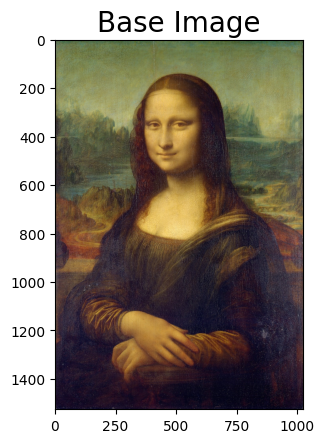

In [6]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(base_image_path)
plt.imshow(img1)

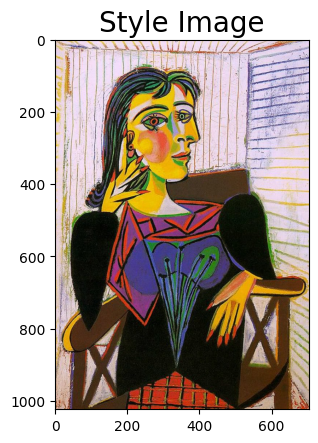

In [7]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = load_img(style_path + 'Pablo_Picasso/Pablo_Picasso_92.jpg')
plt.imshow(img1)

In [8]:
import PIL.Image
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [9]:
def load_image(path_to_image):
    max_dim = 512
    img = tf.io.read_file(path_to_image)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    print(img.shape)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(scale*shape, tf.int32)
    img = tf.image.resize(img, new_shape)
    print(img.shape)
    img = img[tf.newaxis, :]
    return img

In [10]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

(1526, 1024, 3)
(512, 343, 3)
(1024, 704, 3)
(512, 352, 3)
(1, 512, 343, 3)


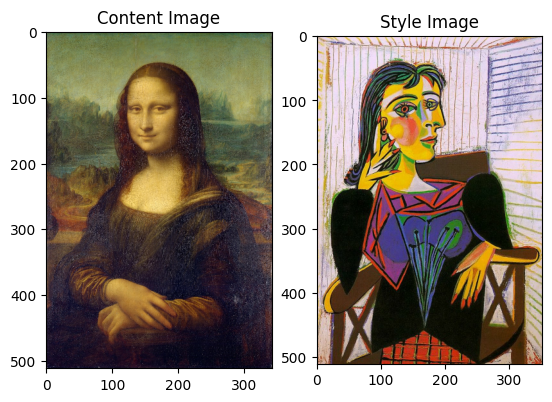

In [11]:
content_image = load_image(base_image_path)
style_image = load_image(style_image_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')
print(content_image.shape)

In [12]:
x = vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
weights = '/kaggle/input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
vgg = vgg19.VGG19(include_top=True, weights=weights)
prediction_probabilities = vgg(x)
print(prediction_probabilities.shape)
# prediction_probabilities

(1, 1000)


In [13]:
vgg = vgg19.VGG19(include_top=False, weights='imagenet')
print()
for layer in vgg.layers:
    print(layer.name)

80134624/80134624 [==============================] - 0s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [14]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [15]:
def get_vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [16]:
style_extractor = get_vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 512, 352, 64)
  min:  0.0
  max:  805.5846
  mean:  31.80531

block2_conv1
  shape:  (1, 256, 176, 128)
  min:  0.0
  max:  3808.969
  mean:  185.08429

block3_conv1
  shape:  (1, 128, 88, 256)
  min:  0.0
  max:  9491.428
  mean:  219.64503

block4_conv1
  shape:  (1, 64, 44, 512)
  min:  0.0
  max:  20860.137
  mean:  736.822

block5_conv1
  shape:  (1, 32, 22, 512)
  min:  0.0
  max:  3338.553
  mean:  59.138393



In [17]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [18]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = get_vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [19]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [20]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0012830095
    max:  21584.713
    mean:  358.25687

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  62547.31
    mean:  9508.761

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  187130.8
    mean:  7956.9023

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4281936.0
    mean:  177486.28

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  69882.57
    mean:  1152.8999

Contents:
   block5_conv2
    shape:  (1, 32, 21, 512)
    min:  0.0
    max:  1339.7878
    mean:  12.6633215


In [21]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [22]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))

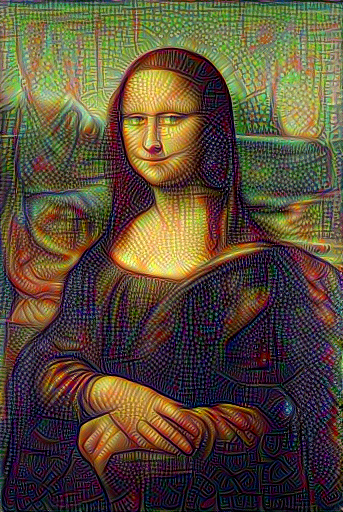

Train step: 10
Total time: 3.9


In [23]:
import time
import IPython.display as display
start = time.time()

epochs = 1
steps_per_epoch = 10
step = 0


image = tf.Variable(content_image)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4


for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

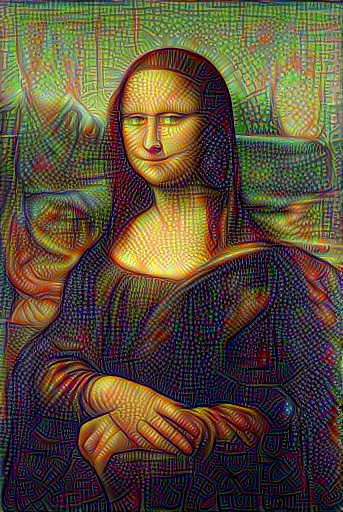

Train step: 10
Total time: 1.5


In [24]:
import time
start = time.time()

epochs = 1
steps_per_epoch = 10
total_variation_weight=30

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)


@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

    

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))